<a name="Import-and-read-data"></a>
# Import and read data


In [17]:
!pip install category_encoders

In [18]:
import os
import pandas as pd
import numpy as np
from datetime import datetime
start_time = datetime.now()


import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams

%matplotlib inline
# figure size in inches
rcParams['figure.figsize'] = 8,6


# Plotly visualizations
from plotly import tools
# import chart_studio.plotly as py
import plotly.figure_factory as ff
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

import plotly.offline as pyo
import plotly.express as px
init_notebook_mode(connected=True)

# For oversampling Library (Dealing with Imbalanced Datasets)
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.preprocessing import LabelEncoder
# For undersamping
from imblearn.under_sampling import RandomUnderSampler

# for encoding and normalization
from category_encoders import TargetEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline

from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold, StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression

from sklearn.feature_selection import VarianceThreshold

# import lightgbm as lgb
import math
import itertools as it
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
import warnings
warnings.filterwarnings("ignore")

# Classifiers
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Other machine learning tools

from sklearn.feature_selection import RFECV
import scipy.stats as sps

from sklearn.ensemble import BaggingClassifier

print('LOADING DURATION: ', datetime.now() - start_time)


pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 20)

LOADING DURATION:  0:00:18.003441


# Import and read data

In [19]:
start_time_proyecto = datetime.now()

start_time_pd = datetime.now()

df = pd.read_csv("/kaggle/input/lending-club/accepted_2007_to_2018q4.csv/accepted_2007_to_2018Q4.csv")

df = df.dropna(subset=["loan_status"])


In [23]:
#df.head()
#df.tail()
df.shape

(2260668, 151)

In [24]:
#reduce the data size to fasten following steps, otherwise the memory will soon run out
complete_df = df.sample(n=100000, random_state=42)

In [26]:
print('LOADING DURATION: ', datetime.now() - start_time_pd)

LOADING DURATION:  0:01:22.945110


In [27]:
import numpy as np
import pandas as pd

# show more of the dataframe in notebook output
pd.set_option("display.max_rows", 80)       # increase if you like
pd.set_option("display.max_columns", None)  # show all columns
pd.set_option("display.width", 2000)
pd.set_option("display.colheader_justify", "center")


In [28]:
df = complete_df.copy()  # keep your original safe

# --- helpers ---
def _to_num(s):
    return pd.to_numeric(s, errors="coerce")

def _exists(col):
    return col in df.columns

# 2.1 Term in months (from '36 months' -> 36)
if _exists("term"):
    df["term_months"] = _to_num(df["term"].astype(str).str.extract(r"(\d+)")[0])

# 2.2 Grade/Subgrade to numeric (A..G => 1..7 ; A1..G5 => 11..75)
if _exists("grade"):
    grade_map = {g:i for i,g in enumerate(list("ABCDEFG"), start=1)}
    df["grade_num"] = df["grade"].map(grade_map)
if _exists("sub_grade"):
    # e.g., 'B3' -> 13 if A1..A5=11..15, B1..B5=21..25, etc.
    sg = df["sub_grade"].astype(str).str.extract(r"([A-G])(\d)")[0].fillna("")
    sn = df["sub_grade"].astype(str).str.extract(r"([A-G])(\d)")[1].astype(float)
    base = sg.map({g:i*10 for i,g in enumerate(list("XABCDEFG"), start=0)})  # A->10, B->20...
    df["sub_grade_num"] = base + sn

# 2.3 Employment length to integer years (keep your mapping but ensure numeric)
if _exists("emp_length"):
    mapping = {
        "10+ years": 10, "9 years": 9, "8 years": 8, "7 years": 7, "6 years": 6,
        "5 years": 5, "4 years": 4, "3 years": 3, "2 years": 2, "1 year": 1,
        "< 1 year": 0, "n/a": np.nan, "NaN": np.nan, None: np.nan
    }
    df["emp_length_int"] = df["emp_length"].map(mapping)

# 2.4 Region from state (keep yours; add if missing)
if _exists("addr_state") and "region" not in df.columns:
    state_to_region = {
        # West
        "AK":"West","AZ":"West","CA":"West","CO":"West","HI":"West","ID":"West","MT":"West",
        "NM":"West","NV":"West","OR":"West","UT":"West","WA":"West","WY":"West",
        # Midwest
        "IA":"Midwest","IL":"Midwest","IN":"Midwest","KS":"Midwest","MI":"Midwest","MN":"Midwest",
        "MO":"Midwest","ND":"Midwest","NE":"Midwest","OH":"Midwest","SD":"Midwest","WI":"Midwest",
        # Northeast
        "CT":"NorthEast","MA":"NorthEast","ME":"NorthEast","NH":"NorthEast","NJ":"NorthEast",
        "NY":"NorthEast","PA":"NorthEast","RI":"NorthEast","VT":"NorthEast","DC":"NorthEast",
        # South
        "AL":"South","AR":"South","DE":"South","FL":"South","GA":"South","KY":"South","LA":"South",
        "MD":"South","MS":"South","NC":"South","OK":"South","SC":"South","TN":"South","TX":"South",
        "VA":"South","WV":"South"
    }
    df["region"] = df["addr_state"].map(state_to_region)

# 2.5 Issued year/month (works if issue_d is datetime or string like 'Jan-2015')
if _exists("issue_d"):
    if not np.issubdtype(df["issue_d"].dtype, np.datetime64):
        df["issue_d"] = pd.to_datetime(df["issue_d"], errors="coerce")
    df["issue_year"] = df["issue_d"].dt.year
    df["issue_month"] = df["issue_d"].dt.month

# 2.6 Numeric clean-ups (interest rate %, revol_util %)
if _exists("int_rate"):
    df["int_rate_num"] = _to_num(df["int_rate"].astype(str).str.replace("%","", regex=False))
if _exists("revol_util"):
    df["revol_util_num"] = _to_num(df["revol_util"].astype(str).str.replace("%","", regex=False))

# 2.7 Income log & bins
if _exists("annual_inc"):
    df["annual_inc_log"] = np.log1p(_to_num(df["annual_inc"]))
    df["income_band"] = pd.qcut(_to_num(df["annual_inc"]), q=5, duplicates="drop")

# 2.8 Debt-to-income buckets (if dti exists)
if _exists("dti"):
    df["dti_bucket"] = pd.cut(_to_num(df["dti"]),
                              bins=[-np.inf, 10, 20, 30, 40, np.inf],
                              labels=["<=10","10–20","20–30","30–40",">40"])

# 2.9 Ratios: loan-to-income & installment-to-income
if _exists("loan_amnt") and _exists("annual_inc"):
    df["loan_to_income"] = _to_num(df["loan_amnt"]) / _to_num(df["annual_inc"])
if _exists("installment") and _exists("annual_inc"):
    df["inst_to_income_month"] = _to_num(df["installment"]) / (_to_num(df["annual_inc"])/12)

# 2.10 Total interest over life (approx)
if _exists("installment") and _exists("term_months") and _exists("loan_amnt"):
    df["total_interest_paid_est"] = _to_num(df["installment"]) * _to_num(df["term_months"]) - _to_num(df["loan_amnt"])

# 2.11 Simplify verification & home ownership flags
if _exists("verification_status"):
    df["is_verified"] = df["verification_status"].astype(str).str.contains("Verified", case=False, na=False).astype(int)
if _exists("home_ownership"):
    df["owns_home"] = df["home_ownership"].isin(["MORTGAGE","OWN"]).astype(int)

# 2.12 (Optional) your label already exists as 'loan_condition'/'loan_condition_int'
# Ensure a numeric flag
if _exists("loan_condition"):
    df["loan_condition_flag"] = (df["loan_condition"].astype(str).str.contains("Bad", case=False, na=False)).astype(int)


In [30]:
def keep_existing(d, cols):
    return [c for c in cols if c in d.columns]

table_cols = keep_existing(df, [
    # IDs / basics
    "id","member_id","issue_year","issue_month","region","addr_state",
    # Original features
    "loan_amnt","term","term_months","int_rate","int_rate_num","installment",
    "grade","grade_num","sub_grade","sub_grade_num","emp_length","emp_length_int",
    "annual_inc","annual_inc_log","income_band","verification_status","is_verified",
    "home_ownership","owns_home","purpose",
    "dti","dti_bucket","revol_bal","revol_util","revol_util_num",
    # Engineered ratios
    "loan_to_income","inst_to_income_month","total_interest_paid_est",
    # Outcome
    "loan_status","loan_condition","loan_condition_flag"
])


In [31]:
# prefer 40–60 rows so the table feels substantive
rows_to_show = 40

# If you want the first N rows:
preview_df = df.loc[:, table_cols].head(rows_to_show)

# If you prefer a random sample (repeatable):
# preview_df = df.loc[:, table_cols].sample(rows_to_show, random_state=42)

# Pretty print
preview_df.style\
    .set_caption("Feature-rich preview (engineered attributes included)")\
    .format({
        "annual_inc": "{:,.0f}",
        "loan_amnt": "{:,.0f}",
        "installment": "{:,.2f}",
        "loan_to_income": "{:.3f}",
        "inst_to_income_month": "{:.3f}",
        "total_interest_paid_est": "{:,.0f}",
        "int_rate_num": "{:.2f}",
        "revol_util_num": "{:.1f}"
    })
from IPython.display import display
display(preview_df.style.set_caption("Feature-rich preview (engineered attributes included)"))


,id,member_id,issue_year,issue_month,region,addr_state,loan_amnt,term,term_months,int_rate,int_rate_num,installment,grade,grade_num,sub_grade,sub_grade_num,emp_length,emp_length_int,annual_inc,annual_inc_log,income_band,verification_status,is_verified,home_ownership,owns_home,purpose,dti,dti_bucket,revol_bal,revol_util,revol_util_num,loan_to_income,inst_to_income_month,total_interest_paid_est,loan_status,loan_condition,loan_condition_flag
1758074,9785323,nan,2013,12,NorthEast,PA,28000.000000,36 months,36,6.620000,6.620000,859.710000,A,1,A2,12.000000,10+ years,10.000000,125000.000000,11.736077,"(100000.0, 61000000.0]",Verified,1,MORTGAGE,1,credit_card,25.160000,20–30,26605.000000,88.400000,88.400000,0.224000,0.082532,2949.560000,Fully Paid,Good Loan,0
686539,78558461,nan,2016,5,West,WA,10650.000000,36 months,36,25.110000,25.110000,424.070000,F,6,F1,61.000000,10+ years,10.000000,83000.000000,11.326608,"(75000.0, 100000.0]",Verified,1,MORTGAGE,1,debt_consolidation,16.370000,10–20,9665.000000,69.000000,69.000000,0.128313,0.061311,4616.520000,Fully Paid,Good Loan,0
900731,110757806,nan,2017,6,SouthEast,FL,18000.000000,36 months,36,10.910000,10.910000,588.540000,B,2,B4,24.000000,9 years,9.000000,104000.000000,11.552156,"(100000.0, 61000000.0]",Source Verified,1,MORTGAGE,1,debt_consolidation,27.300000,20–30,32915.000000,49.200000,49.200000,0.173077,0.067908,3187.440000,Current,Good Loan,0
1727935,96668860,nan,2017,1,SouthEast,NC,3975.000000,36 months,36,17.990000,17.990000,143.690000,D,4,D2,42.000000,2 years,2.000000,43000.000000,10.668979,"(42000.0, 58000.0]",Source Verified,1,ANY,0,car,23.670000,20–30,8490.000000,63.400000,63.400000,0.092442,0.040100,1197.840000,Fully Paid,Good Loan,0
539695,118207599,nan,2017,9,SouthEast,VA,4800.000000,36 months,36,16.020000,16.020000,168.810000,C,3,C5,35.000000,< 1 year,0.000000,80000.000000,11.289794,"(75000.0, 100000.0]",Source Verified,1,RENT,0,other,11.370000,10–20,5555.000000,69.400000,69.400000,0.060000,0.025322,1277.160000,Current,Good Loan,0
2153242,120041697,nan,2017,10,NorthEast,NJ,10000.000000,36 months,36,16.020000,16.020000,351.670000,C,3,C5,35.000000,10+ years,10.000000,120000.000000,11.695255,"(100000.0, 61000000.0]",Not Verified,1,MORTGAGE,1,debt_consolidation,30.750000,30–40,11691.000000,65.000000,65.000000,0.083333,0.035167,2660.120000,Current,Good Loan,0
47643,65773560,nan,2015,11,SouthEast,VA,15000.000000,36 months,36,6.240000,6.240000,457.970000,A,1,A2,12.000000,8 years,8.000000,231800.000000,12.353635,"(100000.0, 61000000.0]",Verified,1,MORTGAGE,1,debt_consolidation,11.690000,10–20,2527.000000,2.400000,2.400000,0.064711,0.023709,1486.920000,Fully Paid,Good Loan,0
1360748,145077262,nan,2018,12,West,OR,40000.000000,60 months,60,12.980000,12.980000,909.720000,B,2,B5,25.000000,< 1 year,0.000000,584000.000000,13.277658,"(100000.0, 61000000.0]",Not Verified,1,MORTGAGE,1,debt_consolidation,7.470000,<=10,30588.000000,41.700000,41.700000,0.068493,0.018693,14583.200000,Current,Good Loan,0
1779719,8604784,nan,2013,11,MidWest,IN,8000.000000,36 months,36,9.670000,9.670000,256.900000,B,2,B1,21.000000,10+ years,10.000000,72000.000000,11.184435,"(58000.0, 75000.0]",Not Verified,1,MORTGAGE,1,debt_consolidation,14.750000,10–20,10413.000000,55.700000,55.700000,0.111111,0.042817,1248.400000,Fully Paid,Good Loan,0
511380,127053376,nan,2018,1,SouthWest,TX,8400.000000,36 months,36,9.440000,9.440000,268.850000,B,2,B1,21.000000,< 1 year,0.000000,50000.000000,10.819798,"(42000.0, 58000.0]",Not Verified,1,RENT,0,credit_card,8.760000,<=10,12196.000000,61.000000,61.000000,0.168000,0.064524,1278.600000,Current,Good Loan,0


<a name="Data-Cleaning"></a>
# Data Cleaning

This part includes:


*   Removing Exclusions
*   Missing Value Imputation
*   Removing Outliers

<a name="Removing-exclusions"></a>
## Removing Exclusions

Steps:


1.   Delete `Current` and `Issued` status
(Adjustment: change the classification of good loans and bad loans)
2.   Delete variables with more than 80% missing values
2.   Delete direct indicators
1.   Delete repetitive object variable

In [84]:
complete_df.dtypes

id                     object
member_id             float64
loan_amnt             float64
funded_amnt           float64
funded_amnt_inv       float64
                       ...   
settlement_term       float64
loan_condition_int      int64
loan_condition         object
emp_length_int        float64
region                 object
Length: 155, dtype: object

In [86]:
pd.value_counts(complete_df.loan_status).to_frame().reset_index()

,loan_status,count
0,Fully Paid,47718
1,Current,38822
2,Charged Off,11868
3,Late (31-120 days),946
4,In Grace Period,335
5,Late (16-30 days),185
6,Does not meet the credit policy. Status:Fully ...,88
7,Does not meet the credit policy. Status:Charge...,36
8,Default,2



**1 Ajustment: change the classification of good loans and bad loans**


`Current` and `Issued` should be excluded, as they did not indicate the direction of the loans (it was unclear whether they were associated with good or bad loans).


| Category | Loan Condition | original Loan Status |
| --- | --- | --- |
| Good Loan | 0 | Fully Paid, Current, (Issued) | 
| Bad Loan | 1 | Default, Charged Off, In Grace Period, Late (16-30 days), Late (31-120 days) |

*some dataset with Issued, some without



| Category | Loan Condition | adjuested Loan Status |
| --- | --- | --- |
| Good Loan | 0 | Fully Paid |
| Bad Loan | 1 | Default, Charged Off, In Grace Period, Late (16-30 days), Late (31-120 days) |

In [88]:
start_time_preprocesamiento = datetime.now()

**2 Delete variables with more than 80% missing values**

There are a lot of columns which have huge chunk of data missing. These columns are not necessary for our analysis. The following part will drop any columns where 20% or more data is missing, which means only columns whose number of non-null values is at least 80% of the total number of rows in the dataset will be retained.

In [57]:
def get_missing_value_stats(input_df):
    df_null = pd.DataFrame({
        'Missing Count': input_df.isnull().sum(),
        'Missing Percent': 100 * input_df.isnull().sum() / len(input_df),
        'Type': input_df.dtypes
    })
    missing_values = df_null[df_null['Missing Count'] > 0].sort_values(by='Missing Count', ascending=False) #改
    return missing_values

def get_value_stats(input_df):
    df_null = pd.DataFrame({
        '#Count': input_df.notna().sum(),
        '%Populated': 100 * input_df.notna().sum() / len(input_df),
        '#Unique Values':input_df.nunique(),
        'Most Common Value': input_df.mode().iloc[0],
        'Type': input_df.dtypes
    })

    missing_values = df_null[df_null['#Count'] > 0].sort_values(by='#Count', ascending=False)

    return missing_values

# Finding the the count and percentage of values that are missing.
get_missing_value_stats(drop_df)

NameError: name 'drop_df' is not defined

In [41]:
#drop any columns where over a certain percentage is missing
drop_df = drop_df.dropna(axis=1, thresh=int(0.20*len(drop_df)))
get_missing_value_stats(drop_df)

,Missing Count,Missing Percent,Type
mths_since_recent_bc_dlq,46552,76.092713,float64
mths_since_last_major_derog,44984,73.529700,float64
mths_since_recent_revol_delinq,40485,66.175749,float64
il_util,39485,64.541175,float64
mths_since_rcnt_il,36807,60.163784,float64
all_util,36080,58.975449,float64
inq_fi,36077,58.970545,float64
open_act_il,36077,58.970545,float64
open_rv_12m,36077,58.970545,float64
total_bal_il,36077,58.970545,float64


**3 Delete dynamic indicators**

In fact, certain variables directly indicate the outcome of the `loan condition`, such as the `total_rec_prnp` (Principal received to date) shown in the chart. If this value is equal to the `loan_amnt` (loan amount), it directly signifies that the loan is a good loan. 
In other words, since we assume that we are within the loan repayment period for prediction purposes, we should eliminate variables that change before and after the loan term, and ensure that only variables directly influencing the loan condition outcome are preserved.

In [43]:
direct_indicators = [
    'collection_recovery_fee',
    'last_pymnt_amnt',
    'out_prncp',
    'out_prncp_inv',
    'recoveries',
    'total_pymnt',
    'total_pymnt_inv',
    'total_rec_int',
    'total_rec_late_fee',
    'total_rec_prncp'
]

drop_df.drop(direct_indicators, axis=1, inplace=True)

In [44]:
#drop repeated features
# drop_df.drop(['loan_condition'], axis=1, inplace=True)
# drop_df.drop(['loan_status'], axis=1, inplace=True)
drop_df.drop(['emp_length'], axis=1, inplace=True)

drop_df.drop(['id','emp_title','url','title','zip_code'], axis=1, inplace=True)

# unique values a categorical variable (object) has
drop_df.select_dtypes(include=["object"]).nunique()  #include/exclude

term                      2
grade                     7
sub_grade                35
home_ownership            6
verification_status       3
issue_d                 138
loan_status               8
pymnt_plan                2
purpose                  14
addr_state               50
earliest_cr_line        630
initial_list_status       2
last_pymnt_d            134
last_credit_pull_d      123
application_type          2
hardship_flag             2
disbursement_method       2
debt_settlement_flag      2
loan_condition            2
region                    5
dtype: int64

In [45]:
fillna_df = drop_df.copy()

# for object variables - Get the mode of next payment date and last payment date and the last date credit amount was pulled
for column in ["last_pymnt_d", "last_credit_pull_d"]:  #, 'income_category'
    fillna_df[column] = fillna_df.groupby("region")[column].transform(lambda x: x.fillna(x.mode()))

# for numerical variables
# Get the mode on the number of accounts in which the client is delinquent
fillna_df["pub_rec"] = fillna_df.groupby("region")["pub_rec"].transform(lambda x: x.fillna(x.median()))
# Get the mode of the total number of credit lines the borrower has
fillna_df["total_acc"] = fillna_df.groupby("region")["total_acc"].transform(lambda x: x.fillna(x.median()))

fillna_df["emp_length_int"] = fillna_df.groupby("region")["emp_length_int"].transform(lambda x: x.fillna(x.median()))

# Get the mean of the annual income depending on the region the client is located.
fillna_df["annual_inc"] = fillna_df.groupby("region")["annual_inc"].transform(lambda x: x.fillna(x.mean()))
# Mode of credit delinquencies in the past two years.
fillna_df["delinq_2yrs"] = fillna_df.groupby("region")["delinq_2yrs"].transform(lambda x: x.fillna(x.mean()))

In [46]:
# for other, fill in with zero
fillna_df.fillna(0, inplace=True)
fillna_df.isnull().sum().max() # Maximum number of nulls.

0

In [47]:
len(fillna_df['loan_condition_int'])
# Loan Ratios (Imbalanced classes)
fillna_df['loan_condition_int'].value_counts()/len(fillna_df['loan_condition_int']) * 100

loan_condition_int
0    78.14247
1    21.85753
Name: count, dtype: float64

<a name="Removing-Outliers"></a>
## Removing Outliers

Custom thresholds were used to remove outliers
(3-sigma method did not work well)

In [48]:
#Custom thresholds
RemoveOutlier_df = fillna_df.copy()
print("Dataset before removing outlier:",RemoveOutlier_df.shape)
RemoveOutlier_df = RemoveOutlier_df[RemoveOutlier_df['annual_inc'] <= 250000]
RemoveOutlier_df = RemoveOutlier_df[RemoveOutlier_df['dti'] <= 50]
RemoveOutlier_df = RemoveOutlier_df[RemoveOutlier_df['open_acc'] <= 40]
RemoveOutlier_df = RemoveOutlier_df[RemoveOutlier_df['total_acc'] <= 80]
RemoveOutlier_df = RemoveOutlier_df[RemoveOutlier_df['revol_util'] <= 120]
RemoveOutlier_df = RemoveOutlier_df[RemoveOutlier_df['revol_bal'] <= 250000]
RemoveOutlier_df.reset_index(drop=True, inplace=True)
print("Dataset after removing outlier:",RemoveOutlier_df.shape)

RemoveOutlier_df.head().transpose()

Dataset before removing outlier: (61178, 99)
Dataset after removing outlier: (60253, 99)


,0,1,2,3,4
loan_amnt,28000.0,10650.0,3975.0,15000.0,8000.0
funded_amnt,28000.0,10650.0,3975.0,15000.0,8000.0
funded_amnt_inv,28000.0,10650.0,3975.0,15000.0,8000.0
term,36 months,36 months,36 months,36 months,36 months
int_rate,6.62,25.11,17.99,6.24,9.67
...,...,...,...,...,...
debt_settlement_flag,N,N,N,N,N
loan_condition_int,0,0,0,0,0
loan_condition,Good Loan,Good Loan,Good Loan,Good Loan,Good Loan
emp_length_int,10.0,10.0,2.0,8.0,10.0


In [49]:
print('LOADING DURATION: ', datetime.now() - start_time_preprocesamiento)

LOADING DURATION:  0:00:31.713042


<a name="Feature-Engineering"></a>
# Feature Engineering

Steps:
- **Binary Encoding** for binary (Boolean) variables
- **Target Encoding** for multivariate variables
- **Normalization** for numeric variables


Note:
In order to prevent data leakage, target encoding and normalization should only be completed on the training set, and then use the same rules to change the test set.


Something to mention:

- Train Test Split: use StrattifiedShuffleSplit to have approximately the same ratio of bad loans compared to good loans in both training and testing data. --important to imbalanced dataset
- Target Encoding: use smooth method to avoid overfitting


In [54]:
start_time_feature_eng = datetime.now()

In [55]:
TE_df = RemoveOutlier_df.copy()

In [56]:
# divide variables into numerical variables and categorical variables, categorical variables are divided into binary variables and multivariate variables
original_cols = TE_df.columns

cat_cols = TE_df.select_dtypes(include=['object']).columns.tolist()
num_cols = [col for col in TE_df.select_dtypes(exclude=['object']).columns.tolist() if col not in ['id', 'loan_condition_int']]

dual_cat_cols = [col for col in cat_cols if TE_df[col].nunique()<=2]
multi_cat_cols =[col for col in cat_cols if TE_df[col].nunique()>2]

multi_cat_cols

['grade',
 'sub_grade',
 'home_ownership',
 'verification_status',
 'issue_d',
 'loan_status',
 'purpose',
 'addr_state',
 'earliest_cr_line',
 'last_pymnt_d',
 'last_credit_pull_d',
 'region']

<a name="Binary-Encoding"></a>
## Binary Encoding for Binary Variables

In [57]:
# pair all categorical features with another categorical feature
import itertools
def combine_categories(dataframe, cat_cols, expand_dim=False):
    df = dataframe.copy()
    combined = list(itertools.combinations(cat_cols, 2))
    for c1, c2 in combined:
        df.loc[:, f'{c1}__{c2}'] = df[c1].astype(str) + '_' + df[c2].astype(str)
        if expand_dim:
            cat_cols.append(f'{c1}__{c2}')
    return df, cat_cols

# binary encoding for dual_cat_cols
TE_df = pd.get_dummies(TE_df, columns=dual_cat_cols, drop_first=True)

# update dual_cat_cols
changed_columns = [col for col in TE_df.columns if col not in original_cols]
dual_cat_cols = changed_columns

TE_df.head().transpose()

,0,1,2,3,4
loan_amnt,28000.0,10650.0,3975.0,15000.0,8000.0
funded_amnt,28000.0,10650.0,3975.0,15000.0,8000.0
funded_amnt_inv,28000.0,10650.0,3975.0,15000.0,8000.0
int_rate,6.62,25.11,17.99,6.24,9.67
installment,859.71,424.07,143.69,457.97,256.9
...,...,...,...,...,...
application_type_Joint App,False,False,False,False,False
hardship_flag_Y,False,False,False,False,False
disbursement_method_DirectPay,False,False,False,False,False
debt_settlement_flag_Y,False,False,False,False,False


In [58]:
print('LOADING DURATION: ', datetime.now() - start_time_preprocesamiento)

LOADING DURATION:  0:01:43.586590


## 🔪Train Test Split

The purpose of the code below is to have the same ratio across our training and test sets.

This should better be done before target encoding and normalization to avoid data leakage.

In [59]:
from sklearn.model_selection import StratifiedShuffleSplit

stratified = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42) #Specify test_size to account for 20%

for train_set, test_set in stratified.split(TE_df, TE_df[target_col]):
    stratified_train = TE_df.loc[train_set]
    stratified_test = TE_df.loc[test_set]

train_df = stratified_train
test_df = stratified_test

# Let's Shuffle the data
train_df = train_df.sample(frac=1).reset_index(drop=True)
test_df = test_df.sample(frac=1).reset_index(drop=True)

print(train_df[target_col].value_counts()/len(TE_df))
print(test_df[target_col].value_counts()/len(TE_df))
train_df.shape

loan_condition_int
0    0.625098
1    0.174896
Name: count, dtype: float64
loan_condition_int
0    0.156291
1    0.043716
Name: count, dtype: float64


(48202, 99)

In [60]:
# separates the y(target variables) and X(features) for the training and testing datasets

train_y = train_df[[target_col]]
test_y = test_df[[target_col]]

train_X = train_df.drop(target_col, axis=1, inplace=False)
test_X = test_df.drop(target_col, axis=1, inplace=False)

train_X.shape

(48202, 98)

until now, we have：


| train vs test | X | y |
| --- | --- | --- |
| train | `train_X` | `train_y` |
| test | `test_X` | `test_y` |

<a name="Target-Encoding"></a>
## Target Encoding for Multicategorical Variables

In [61]:
# Create a data set containing only multi-categorical variables
multi_cat_train_X = train_X[multi_cat_cols]
multi_cat_test_X = test_X[multi_cat_cols]

# Target encode categorical variables with smoothing method (on train set)
encoder = TargetEncoder(smoothing=0.2)
encoder.fit(multi_cat_train_X, train_y)

# Apply the same encoding rules on train and test set
encoded_multi_cat_train_X = encoder.transform(multi_cat_train_X)
encoded_multi_cat_test_X = encoder.transform(multi_cat_test_X)

encoded_train_X = pd.concat([train_X.drop(columns=multi_cat_cols), encoded_multi_cat_train_X], axis=1)
encoded_test_X = pd.concat([test_X.drop(columns=multi_cat_cols), encoded_multi_cat_test_X], axis=1)

encoded_train_X.head().transpose()

,0,1,2,3,4
loan_amnt,16000.0,15000.0,1500.0,6100.0,12600.0
funded_amnt,16000.0,15000.0,1500.0,6100.0,12600.0
funded_amnt_inv,16000.0,15000.0,1500.0,6100.0,12600.0
int_rate,12.99,20.0,14.16,24.08,15.31
installment,539.03,397.41,51.39,239.58,438.7
...,...,...,...,...,...
addr_state,0.193569,0.244886,0.220217,0.203125,0.203125
earliest_cr_line,0.174603,0.244094,0.257485,0.213115,0.256757
last_pymnt_d,0.181467,0.182247,0.211538,0.24359,0.191358
last_credit_pull_d,0.0,0.196957,0.088235,0.297327,0.295515


until now, we have：


| train vs test | X | y |
| --- | --- | --- |
| train | `encoded_train_X` | `train_y` |
| test | `encoded_test_X` | `test_y` |

<a name="Normalization"></a>
## Normalization for Numeric Variables

In [62]:
scaler = StandardScaler()

# Fit and apply normalization on the training set
standardized_train_X = encoded_train_X.copy()
standardized_train_X[num_cols] = scaler.fit_transform(encoded_train_X[num_cols])

# Apply the same normalization rules on the test set
standardized_test_X = encoded_test_X.copy()
standardized_test_X[num_cols] = scaler.transform(encoded_test_X[num_cols])

standardized_train_X.head().transpose()

,0,1,2,3,4
loan_amnt,0.190865,0.074976,-1.489529,-0.956438,-0.203158
funded_amnt,0.191703,0.075768,-1.489362,-0.956059,-0.202478
funded_amnt_inv,0.194659,0.078809,-1.48516,-0.952252,-0.19923
int_rate,-0.070622,1.401446,0.175073,2.258227,0.416567
installment,0.397357,-0.149676,-1.48624,-0.759322,0.009814
...,...,...,...,...,...
addr_state,0.193569,0.244886,0.220217,0.203125,0.203125
earliest_cr_line,0.174603,0.244094,0.257485,0.213115,0.256757
last_pymnt_d,0.181467,0.182247,0.211538,0.24359,0.191358
last_credit_pull_d,0.0,0.196957,0.088235,0.297327,0.295515


until now, we have：


| train vs test | X | y |
| --- | --- | --- |
| train | `standardized_train_X` | `train_y` |
| test | `standardized_test_X` | `test_y` |

In [63]:
print('LOADING DURATION: ', datetime.now() - start_time_feature_eng)

LOADING DURATION:  0:00:21.422488


<a name="Dealing-with-Imbalanced-Dataset"></a>
# Dealing with Imbalanced Dataset
Our data set is an unbalanced data set (80% good loans). What we are more concerned about is the accuracy of bad loan prediction, so balancing the data is particularly important.



Balanced data can be oversampled or undersampled. Random undersampling and SMOTE (oversampling) methods are provided below. Since the data set is very large, the data set after undersampling is used subsequently. In comparison, the authenticity of the data is guaranteed.

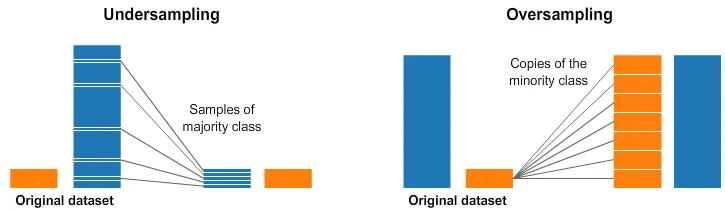

Undersamping our data

In [67]:
undersampler = RandomUnderSampler(random_state=42)

# Undersampling the training set
standardized_train_X_undersample, train_y_undersample = undersampler.fit_resample(standardized_train_X, train_y) 


print('standardized_train_X_undersample.shape',standardized_train_X_undersample.shape)
pd.value_counts(train_y_undersample.loan_condition_int).to_frame()

standardized_train_X_undersample.shape (21076, 98)


,count
loan_condition_int,
0,10538
1,10538


until now (undersampling), we have：


| train vs test | X | y |
| --- | --- | --- |
| train | standardized_train_X_undersample | train_y_undersample |
| test | standardized_test_X | test_y |

Or you can use SMOTE. After testing, the effect is similar to the model after Undersampling.

In [68]:
# smote = SMOTE(random_state=42)

# # oversampling the training set
# train_X_SMOTE, train_y_SMOTE = smote.fit_resample(standardized_train_X, train_y)

<a name="Feature-Selection"></a>
# Feature Selection


*   Filter
*   Wrapper



In [69]:
selector = VarianceThreshold(threshold=1)
selector.fit(standardized_train_X_undersample)

filtered_feature_names = standardized_train_X_undersample.columns[selector.get_support()]
standardized_train_X_undersample_filtered = standardized_train_X_undersample[filtered_feature_names]

standardized_train_X_undersample_filtered.shape

(21076, 46)

In [71]:
#modify this if you want to use SMOTE
to_wrap_train_X = standardized_train_X_undersample_filtered.copy()
train_y = train_y_undersample.copy()

In [72]:
nfeatures = len(to_wrap_train_X.columns)
nfeatures

46

Stepwise selection wrapper will take a lot of time, so you can skip it directly and use the results I got after running it, as follows:

In [74]:
vars_final = ['delinq_2yrs',
 'last_fico_range_high',
 'last_fico_range_low',
 'acc_now_delinq',
 'open_acc_6m',
 'total_bal_il',
 'il_util',
 'open_rv_12m',
 'all_util']

Or if you have time you can run it yourself （Ctrl+/ Uncomment and run）

In [75]:
# %%time
# import warnings
# warnings.filterwarnings("ignore", category=DeprecationWarning)

# nfeatures = len(to_wrap_train_X.columns)
# clf = RandomForestClassifier(n_estimators=5, n_jobs=-1)
# sfs = SFS(clf, k_features=nfeatures, forward=True, verbose=2, cv=2, n_jobs=-1)
# sfs.fit(to_wrap_train_X, train_y)

# from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
# vars_FS = pd.DataFrame.from_dict(sfs.get_metric_dict()).T
# vars_FS

In [76]:
# vars_final = list(vars_FS.loc[15, 'feature_names'])
# vars_final

In [77]:
# fig1 = plot_sfs(sfs.get_metric_dict(),kind='std_dev', figsize=(8, 5))
# plt.xticks(np.arange(0, len(to_wrap_train_X.columns), step=5))

# # plt.ylim([0.9, 1.0])
# plt.xlim(0,len(to_wrap_train_X.columns))
# plt.title('Stepwise Selection')
# plt.grid()
# plt.show()

In [78]:
# Use wrapper to reduce variables
wrapped_train_X = to_wrap_train_X.filter(vars_final, axis=1)
wrapped_test_X = standardized_test_X.filter(vars_final, axis=1)


print("final train/test X shape (target encoded):", wrapped_train_X.shape, wrapped_test_X.shape)
print("final train/test y shape:", train_y.shape, test_y.shape)

final train/test X shape (target encoded): (21076, 9) (12051, 9)
final train/test y shape: (21076, 1) (12051, 1)


In [79]:
wrapped_train_X.head()

,delinq_2yrs,last_fico_range_high,last_fico_range_low,acc_now_delinq,open_acc_6m,total_bal_il,il_util,open_rv_12m,all_util
23171,0.794500,0.043116,0.126100,-0.066139,-0.459917,-0.456882,-0.685557,-0.472138,-0.7518
15560,-0.363123,1.455550,0.990408,-0.066139,-0.459917,-0.456882,-0.685557,-0.472138,-0.7518
47789,-0.363123,1.516960,1.027987,-0.066139,-0.459917,-0.456882,-0.685557,-0.472138,-0.7518
28467,-0.363123,-2.044828,-1.151573,-0.066139,-0.459917,-0.456882,-0.685557,-0.472138,-0.7518
5847,-0.363123,0.718628,0.539465,-0.066139,-0.459917,-0.456882,-0.685557,-0.472138,-0.7518


In [80]:
print('LOADING DURATION AD: ', datetime.now() - start_time_ad)

LOADING DURATION AD:  0 days 00:03:03.653671


until now, we have：


| train vs test | X | y |
| --- | --- | --- |
| train | wrapped_train_X | train_y |
| test | wrapped_test_X | test_y |

<a name="Model-Building"></a>
# Model Building

Models:


*   Logistic Regression
*   Decision Tree
*   K Nearest Neighbors
*   Random Forest
*   Gaussian Naive Bayes
*   Light GBM
*   XGBoost
*   Gradient Boosting
*   Neural Network

**5-fold Cross Validation**: The model was trained on the training set and 5-fold cross-validation was used to assess model accuracy during training.



In [89]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

def plot_confusion_matrix(mean_conf_matrix, xtick_labels=None, ytick_labels=None):
    fig, axes = plt.subplots(figsize=(8, 6))
    default_style = sns.axes_style()
    # sns.set(font_scale=1.5)
    ax = sns.heatmap(mean_conf_matrix.T, annot=True, cmap='Blues', fmt=".1f",annot_kws={"size": 18})
    if xtick_labels:
        ax.set_xticklabels(xtick_labels)
    if ytick_labels:
        ax.set_yticklabels(ytick_labels)


    ax.set_xlabel('True Label')
    ax.set_ylabel('Predicted Label')
    ax.axis('equal')
    plt.title('Mean Confusion Matrix')
    sns.set_style(default_style)
    plt.show()

def calculate_scores(model, X_trn, y_trn, X_tst, y_tst):
    """Calculate various classification scores on the test set"""
    model.fit(X_trn, y_trn)
    y_pred = model.predict(X_tst)
    accuracy = accuracy_score(y_tst, y_pred)

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(y_tst, y_pred)

    # Calculate precision, recall, and F1-score
    precision = precision_score(y_tst, y_pred)
    recall = recall_score(y_tst, y_pred)
    f1 = f1_score(y_tst, y_pred)

    y_pred_proba = model.predict_proba(X_tst)[:,1]
    auc = roc_auc_score(y_tst, y_pred_proba)

    mask = y_tst['loan_condition_int'].astype(bool).values
    churn = y_pred_proba[mask]
    not_churn = y_pred_proba[~mask]
    ks = sps.ks_2samp(churn, not_churn)[0]

    return accuracy, auc, ks, conf_matrix, precision, recall, f1

def fit_first_level(models, X_trn, y_trn, X_tst):
    """
    Prepare first-level model fitting for stacking. Only used during model stacking.
    Output the predicted probabilities of the first-level models as features for the stacking model.
    """
    # Create dataframes to store predictions of the first-level models
    X2_trn = np.zeros((len(X_trn), 2 * len(models)))
    X2_tst = np.zeros((len(X_tst), 2 * len(models)))

    for i, model in enumerate(models.values()):
        print("Stacking with", model)

        model.fit(X_trn, y_trn)
        y_trn_pred_proba = model.predict_proba(X_trn)
        y_tst_pred_proba = model.predict_proba(X_tst)

        X2_trn[:, i*2:(i+1)*2] = y_trn_pred_proba
        X2_tst[:, i*2:(i+1)*2] = y_tst_pred_proba

    return X2_trn, X2_tst

def calculate_cv_scores(model, X, y, cv=5, stacking=False, models=None, verbose=False):
    """Calculate average k-fold cross-validated classification scores"""
    kf = KFold(n_splits=cv, shuffle=True)
    accuracy_scores = []
    auc_scores = []
    ks_scores = []
    conf_matrices = []  # Store confusion matrices for each fold
    precision_scores = []
    recall_scores = []
    f1_scores = []
    fold_count = 0

    for train_index, test_index in kf.split(X):
        X_trn, X_tst = X.iloc[train_index], X.iloc[test_index]
        y_trn, y_tst = y.iloc[train_index], y.iloc[test_index]

        if stacking:
            # smote = False
            X_trn, X_tst = fit_first_level(models, X_trn, y_trn, X_tst)

        accuracy, auc, ks, conf_matrix, precision, recall, f1 = calculate_scores(model, X_trn, y_trn, X_tst, y_tst)
        accuracy_scores.append(accuracy)
        auc_scores.append(auc)
        ks_scores.append(ks)
        conf_matrices.append(conf_matrix)
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)

        # if verbose:
        #     print(f"Fold {fold_count} accuracy, auc, ks:", accuracy, auc, ks)

        fold_count += 1

    # mean confusion matrix
    mean_conf_matrix = np.mean(conf_matrices, axis=0) #/ np.sum(np.mean(conf_matrices, axis=0)))
    print(f"Mean Confusion Matrix for Model:\n", mean_conf_matrix)
    plot_confusion_matrix(mean_conf_matrix, xtick_labels=['Good Loan', 'Bad Loan'], ytick_labels=['Good Loan', 'Bad Loan'])

    return np.mean(accuracy_scores), np.mean(auc_scores), np.mean(ks_scores), np.mean(precision_scores), np.mean(recall_scores), np.mean(f1_scores)

def fit_models_summary(models, X, y, cv=5, smote = False,undersample = False):
    """
    Calculate average k-fold cross-validated classification scores for multiple models.
    Generate a summary dataframe.
    """
    baseline = pd.DataFrame(columns=['accuracy', 'auc', 'ks', 'precision', 'recall', 'f1'])

    for name, model in models.items():
        # accuracy, auc, ks, precision, recall, f1 = calculate_cv_scores(model, X, y, cv=cv, smote=False)
        # baseline.loc[name] = [accuracy, auc, ks, None, precision, recall, f1]

        accuracy, auc, ks, precision, recall, f1 = calculate_cv_scores(model, X, y, cv=cv)

        if smote:
            baseline.loc["{} (SMOTE)".format(name)] = [accuracy, auc, ks, precision, recall, f1]
        if undersample:
            baseline.loc["{} (undersample)".format(name)] = [accuracy, auc, ks, precision, recall, f1]

        print(f"{name} processed")

    return baseline

In [91]:
mss=60
msl=int(mss/2)

models = {
     'Logistic Regression': LogisticRegression(),
     'Decision Tree': DecisionTreeClassifier(max_depth=10,min_samples_split=mss,min_samples_leaf=msl),
     'K Nearest Neighbors': KNeighborsClassifier(n_neighbors=20),
     'Random Forest': RandomForestClassifier(n_estimators=20,max_depth=10),
     'Gaussian Naive Bayes': GaussianNB(var_smoothing=1),
     'Light GBM': LGBMClassifier(n_estimators=50,max_depth=3),
     'XGBoost': XGBClassifier(n_estimators=50,max_depth=3),
     'Gradient Boosting': GradientBoostingClassifier(n_estimators=50,max_depth=3),
     "Neural Network": MLPClassifier(hidden_layer_sizes = (10,10)),
# #     'Support Vector Machine': SVC()
}

In [92]:
start_time_modelos_ind = datetime.now()

Mean Confusion Matrix for Model:
 [[1850.   257.6]
 [ 287.8 1819.8]]


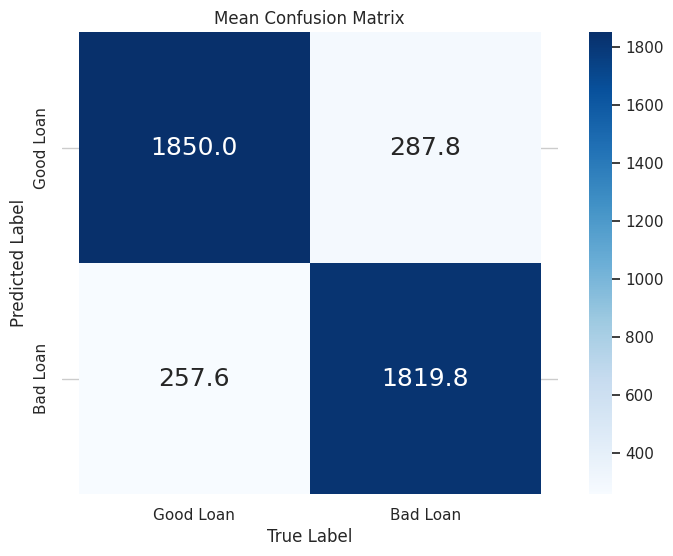

Logistic Regression processed
Mean Confusion Matrix for Model:
 [[1806.8  300.8]
 [ 255.8 1851.8]]


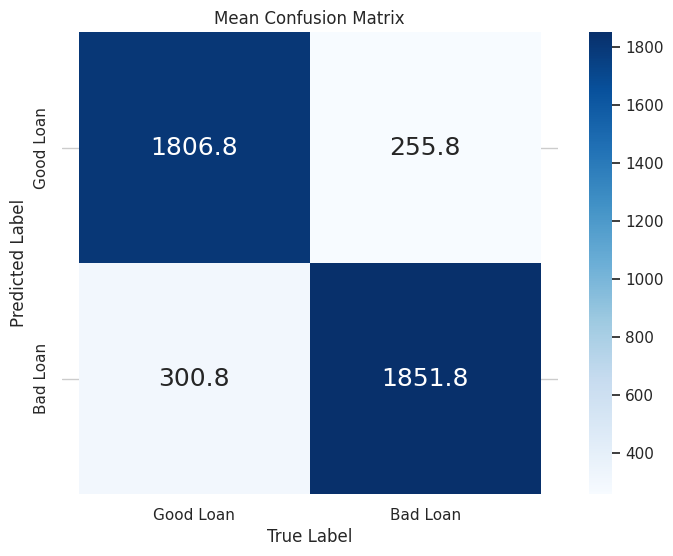

Decision Tree processed
Mean Confusion Matrix for Model:
 [[1977.2  130.4]
 [ 949.6 1158. ]]


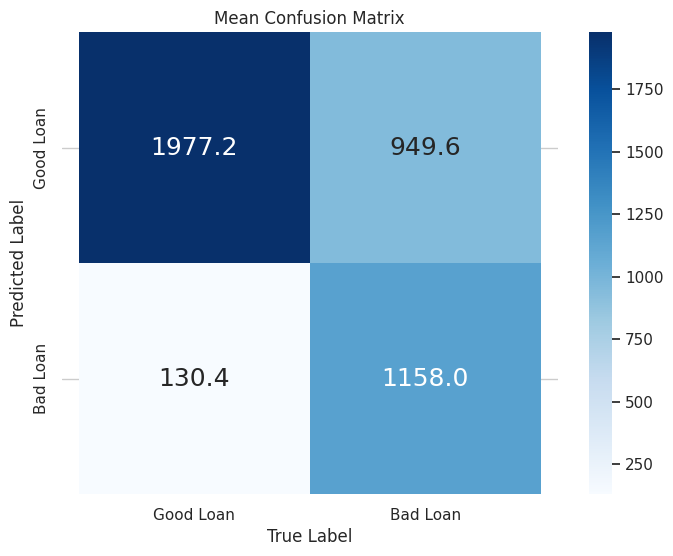

K Nearest Neighbors processed
Mean Confusion Matrix for Model:
 [[1818.2  289.4]
 [ 260.8 1846.8]]


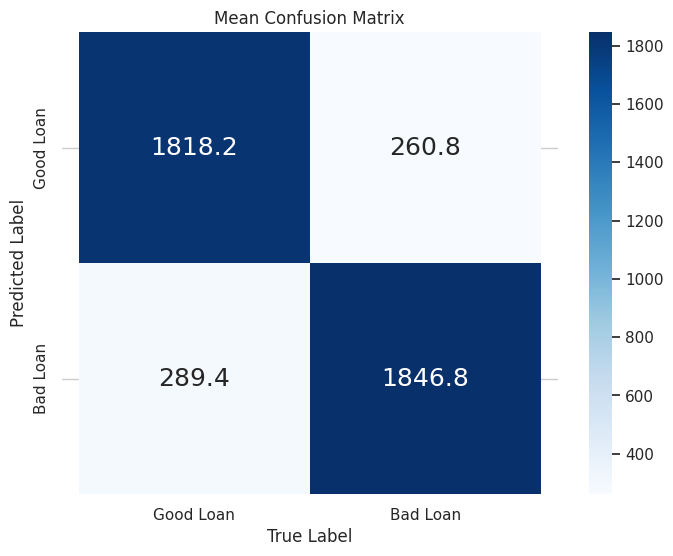

Random Forest processed
Mean Confusion Matrix for Model:
 [[1943.8  163.8]
 [ 701.4 1406.2]]


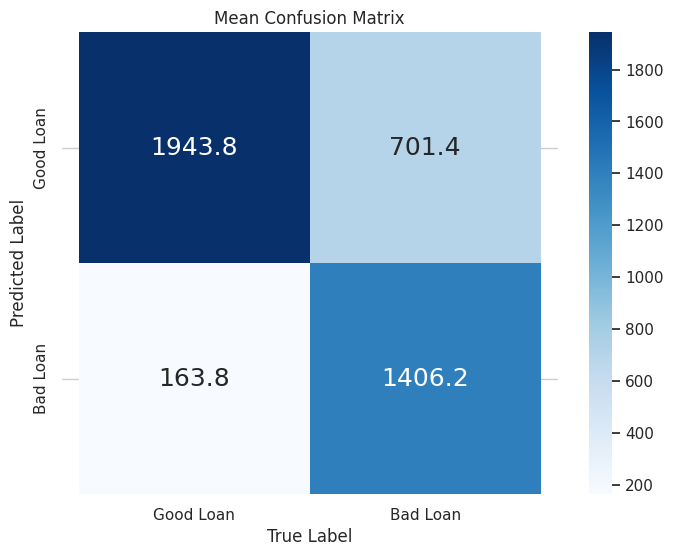

Gaussian Naive Bayes processed
Mean Confusion Matrix for Model:
 [[1820.   287.6]
 [ 253.2 1854.4]]


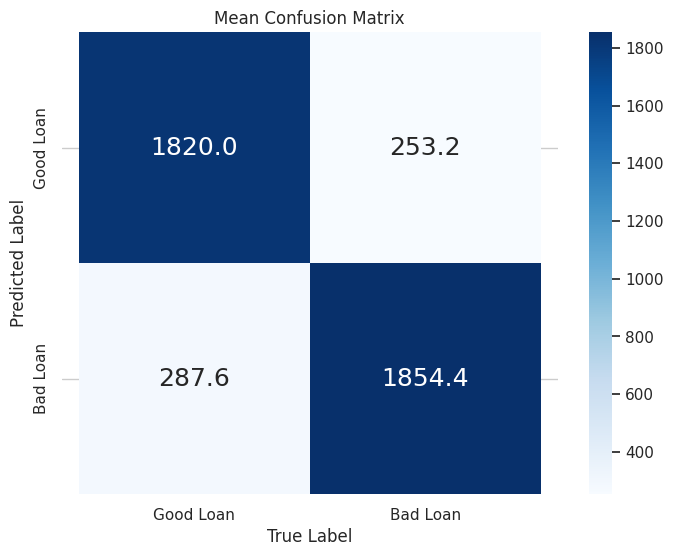

Light GBM processed
Mean Confusion Matrix for Model:
 [[1815.   292.6]
 [ 250.4 1857.2]]


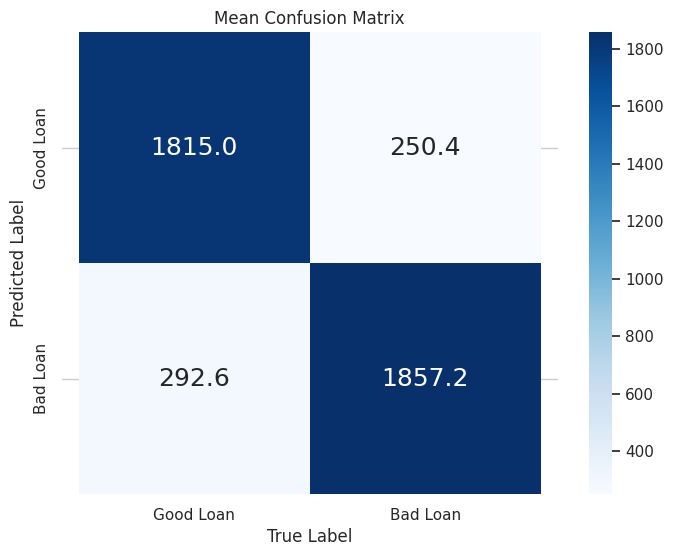

XGBoost processed
Mean Confusion Matrix for Model:
 [[1813.2  294.4]
 [ 245.8 1861.8]]


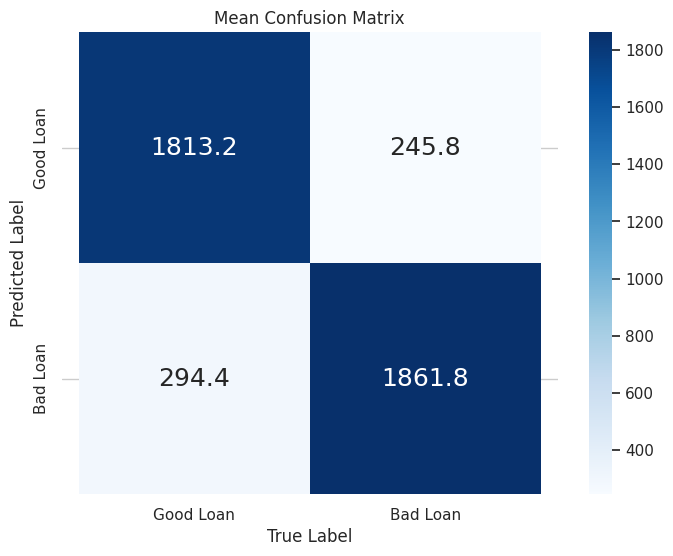

Gradient Boosting processed
Mean Confusion Matrix for Model:
 [[1826.   281.6]
 [ 259.  1848.6]]


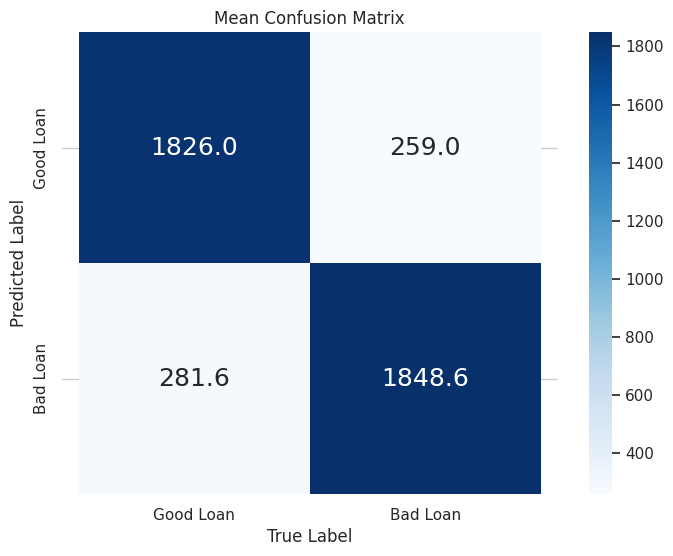

Neural Network processed


In [93]:
# test baseline models on undersampling dataset
baseline_tgt = fit_models_summary(models, wrapped_train_X, train_y, undersample=True)

In [94]:
baseline_tgt

,accuracy,auc,ks,precision,recall,f1
Logistic Regression (undersample),0.870611,0.928347,0.745161,0.876071,0.863476,0.869696
Decision Tree (undersample),0.867954,0.925851,0.739976,0.860338,0.878577,0.869308
K Nearest Neighbors (undersample),0.743784,0.780560,0.509511,0.898928,0.549459,0.681901
Random Forest (undersample),0.869473,0.929219,0.743185,0.864623,0.876254,0.870318
Gaussian Naive Bayes (undersample),0.794743,0.911164,0.691646,0.895802,0.667275,0.764505
Light GBM (undersample),0.871703,0.932363,0.748119,0.865721,0.879886,0.872699
XGBoost (undersample),0.871180,0.931121,0.747315,0.863984,0.881198,0.872455
Gradient Boosting (undersample),0.871845,0.932118,0.748585,0.863479,0.883391,0.873311
Neural Network (undersample),0.871750,0.931255,0.745771,0.867922,0.877186,0.872428


In [95]:
print('LOADING DURATION: ', datetime.now() - start_time_modelos_ind)

LOADING DURATION:  0:00:50.354273


<a name="Model-Stacking"></a>
# Model Bagging and Stacking

Bagging

In [97]:
models = {
     'Logistic Regression': LogisticRegression(),
     'Decision Tree': DecisionTreeClassifier(max_depth=10,min_samples_split=mss,min_samples_leaf=msl),
    #  'K Nearest Neighbors': KNeighborsClassifier(n_neighbors=20),
     'Random Forest': RandomForestClassifier(n_estimators=20,max_depth=10),
    #  'Gaussian Naive Bayes': GaussianNB(var_smoothing=1),
     'Light GBM': LGBMClassifier(n_estimators=50,max_depth=3),
     'XGBoost': XGBClassifier(n_estimators=50,max_depth=3),
     'Gradient Boosting': GradientBoostingClassifier(n_estimators=50,max_depth=3),
     "Neural Network": MLPClassifier(hidden_layer_sizes = (10,10))
}

In [98]:
performance_df = pd.DataFrame(columns=['accuracy', 'auc', 'ks', 'precision', 'recall', 'f1'])

bagging_models = {}

start_time_model_bagging = datetime.now()

for model_name, model in models.items():
    print("processing: ", model_name)
    bagging_model = BaggingClassifier(base_estimator=model, n_estimators=10, random_state=42)

    # Training Bagging model
    bagging_model.fit(wrapped_train_X, train_y)

    bagging_models[model_name + '_bagging'] = bagging_model
    accuracy, auc, ks, conf_matrix, precision, recall, f1 = calculate_scores(bagging_model, wrapped_train_X, train_y, wrapped_test_X, test_y)
    performance_dict = {
        'accuracy': accuracy,
        'auc': auc,
        'ks': ks,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }
    performance_df.loc[model_name + ' (bagging)'] = performance_dict
    
performance_df

processing:  Logistic Regression
processing:  Decision Tree
processing:  Random Forest
processing:  Light GBM
processing:  XGBoost
processing:  Gradient Boosting
processing:  Neural Network


,accuracy,auc,ks,precision,recall,f1
Logistic Regression (bagging),0.872625,0.928025,0.737713,0.660157,0.859909,0.746908
Decision Tree (bagging),0.865488,0.930184,0.740591,0.640812,0.875095,0.739849
Random Forest (bagging),0.865073,0.930867,0.740485,0.640156,0.873956,0.739005
Light GBM (bagging),0.865820,0.931854,0.743137,0.640664,0.879271,0.741239
XGBoost (bagging),0.866567,0.931856,0.743442,0.643136,0.875095,0.741396
Gradient Boosting (bagging),0.865571,0.932097,0.742789,0.639823,0.880790,0.741214
Neural Network (bagging),0.866069,0.932197,0.744717,0.640806,0.881169,0.742008


In [99]:
print('LOADING DURATION: ', datetime.now() - start_time_model_bagging)

LOADING DURATION:  0:07:08.451065


Stacking

Stacking with LogisticRegression()
Stacking with DecisionTreeClassifier(max_depth=10, min_samples_leaf=30, min_samples_split=60)
Stacking with RandomForestClassifier(max_depth=10, n_estimators=20)
Stacking with LGBMClassifier(max_depth=3, n_estimators=50)
Stacking with XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, r

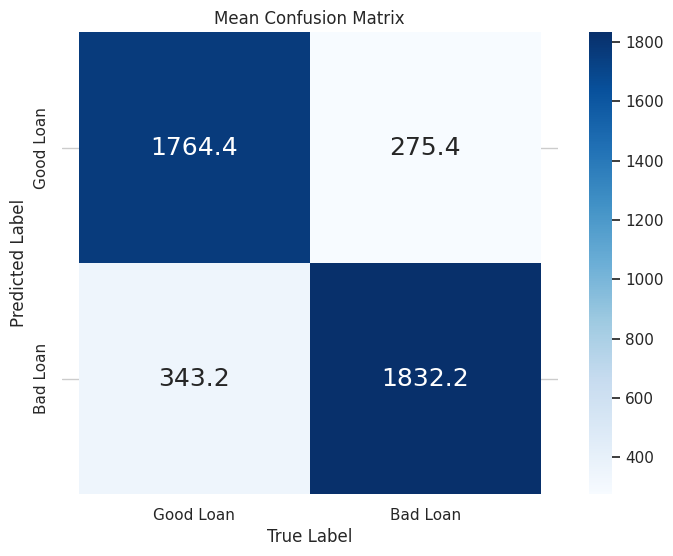

Stacking baseline:
Accuracy: 0.8532452094602047
AUC: 0.9107827550719932
recall: 0.8694402387517552
LOADING DURATION:  0:00:23.045308
CPU times: user 24.9 s, sys: 3.05 s, total: 28 s
Wall time: 23 s


In [101]:
%%time
start_time_model_stacking = datetime.now()

stack_model = XGBClassifier(max_depth = 3)
accuracy, auc, ks, precision, recall, f1 = calculate_cv_scores(stack_model, wrapped_train_X, train_y,
                                        stacking = True, models = models,
                                        verbose = True)
print('Stacking baseline:')
print('Accuracy:', accuracy)
print('AUC:', auc)
print('recall:', recall)

print('LOADING DURATION: ', datetime.now() - start_time_model_stacking)

<a name="Model-Evaluation"></a>
# Model Evaluation on Test Set
**Performance on test set:** models were evaluated on the held-out test set to obtain true test accuracy.

In [103]:
start_time_model_test_set = datetime.now()

In [104]:
holdout_summary = pd.DataFrame(columns = ['accuracy','auc','ks','precision','recall','f1'])

X_trn, y_trn = wrapped_train_X, train_y

for name, model in models.items():
    accuracy, auc, ks, conf_matrix, precision, recall, f1 = calculate_scores(model, X_trn, y_trn, wrapped_test_X, test_y)
    holdout_summary.loc[name] = [accuracy, auc, ks, precision, recall, f1]

X2_trn, X2_tst = fit_first_level(models, wrapped_train_X, train_y, wrapped_test_X)


# add bagging model performance
for model_name, bagging_model in bagging_models.items():
    accuracy, auc, ks, conf_matrix, precision, recall, f1 = calculate_scores(bagging_model, wrapped_train_X, train_y, wrapped_test_X, test_y)
    holdout_summary.loc[model_name] = [accuracy, auc, ks, precision, recall, f1]


# add stack model performance
stack_model = XGBClassifier()
accuracy, auc, ks, conf_matrix, precision, recall, f1 = calculate_scores(stack_model, X2_trn, train_y, X2_tst, test_y)
holdout_summary.loc['Stacking Model (XGB)'] = [accuracy, auc, ks, precision, recall, f1]

Stacking with LogisticRegression()
Stacking with DecisionTreeClassifier(max_depth=10, min_samples_leaf=30, min_samples_split=60)
Stacking with RandomForestClassifier(max_depth=10, n_estimators=20)
Stacking with LGBMClassifier(max_depth=3, n_estimators=50)
Stacking with XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, r

In [105]:
holdout_summary

,accuracy,auc,ks,precision,recall,f1
Logistic Regression,0.872957,0.928051,0.738138,0.660928,0.859909,0.747401
Decision Tree,0.863829,0.925413,0.738854,0.637268,0.875095,0.737482
Random Forest,0.862999,0.929610,0.739105,0.634473,0.880410,0.737478
Light GBM,0.865737,0.931792,0.742394,0.640409,0.879651,0.741203
XGBoost,0.866733,0.931401,0.742046,0.643335,0.875854,0.741801
Gradient Boosting,0.867314,0.931613,0.743060,0.644432,0.876614,0.742802
Neural Network,0.867065,0.931002,0.743623,0.643493,0.878512,0.742857
Logistic Regression_bagging,0.872625,0.928025,0.737713,0.660157,0.859909,0.746908
Decision Tree_bagging,0.865488,0.930184,0.740591,0.640812,0.875095,0.739849
Random Forest_bagging,0.865073,0.930867,0.740485,0.640156,0.873956,0.739005


In [106]:
print('LOADING DURATION: ', datetime.now() - start_time_model_test_set)

LOADING DURATION:  0:14:12.482439


In [107]:
print('LOADING TOTAL DURATION: ', datetime.now() - start_time_proyecto)

LOADING TOTAL DURATION:  0:33:16.615694
